# Exploring Rubin's Galactic Plane Survey Footprint

In [56]:
from rubin_scheduler import scheduler
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from os import path

The Rubin scheduler includes code to describe the regions it formally uses to determine the observing schedule.  The map used for the Galactic Plane region was derived from community recommendations but is not exactly the same, so here we extract the map actually used in the scheduler.

In [37]:
sky_area = scheduler.utils.sky_area.EuclidOverlapFootprint()
healmaps, pix_labels = sky_area.return_maps()
NPIX = hp.nside2npix(sky_area.nside)

In [43]:
def plot_map_data(map, range=None):
    fig = plt.figure(1,(10,10))
    if range == None:
        hp.mollview(map)
    else:
        hp.mollview(map, min=range[0], max=range[1])
    hp.graticule()
    plt.tight_layout()
    plt.close(1)

HEALpixels with NSIDE=32 have an area of 3.357174580844667deg
Total area of footprint = 1530.8716088651681sq.deg


/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_48935/342435702.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


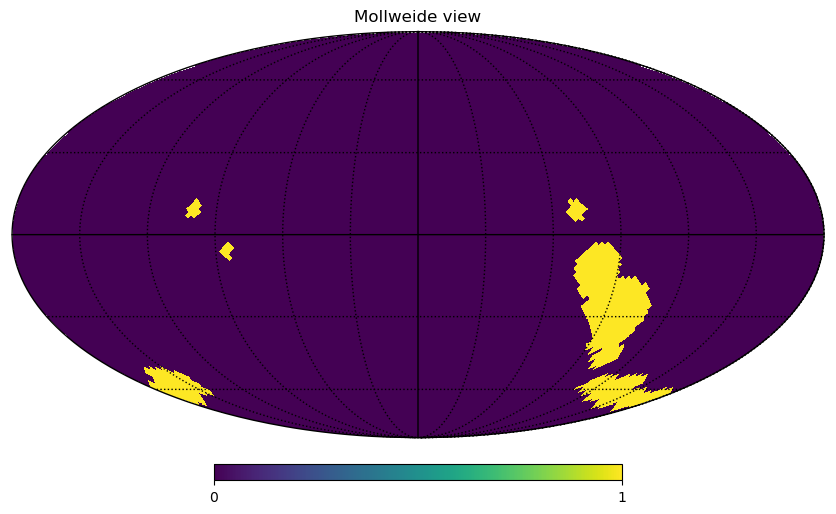

In [44]:
mask = pix_labels == 'bulgy'

# Calculate total footprint area
res = hp.nside2pixarea(sky_area.nside, degrees=True)
print('HEALpixels with NSIDE=' + str(sky_area.nside) + ' have an area of ' + str(res) + 'deg')
idx = np.where(mask)[0]
print('Total area of footprint = ' + str(res*len(idx)) + 'sq.deg')

galplane_footprint = np.zeros(NPIX)
galplane_footprint[mask] = 1.0

plot_map_data(galplane_footprint)

It's been proposed that the 'blob' in the Galactic Plane at high declination should be removed from the footprint, since it is only ever visible from Rubin at high airmass. But let's check what we would not be including if we make this change.  

First, let's isolate the Blob.

In [40]:
def calc_hp_for_region(ra_center, dec_center, radius, NSIDE):
    s = SkyCoord(ra_center*u.deg, dec_center*u.deg, frame='icrs')
    s = s.transform_to('icrs')
    phi = np.deg2rad(s.ra.deg)
    theta = (np.pi/2.0) - np.deg2rad(s.dec.deg)
    radius = max(np.deg2rad(radius),
                 np.deg2rad(hp.max_pixrad(NSIDE, degrees=True)/2.0))
    xyz = hp.ang2vec(theta, phi)
    pixels = hp.query_disc(NSIDE, xyz, radius)
    return pixels

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_48935/342435702.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


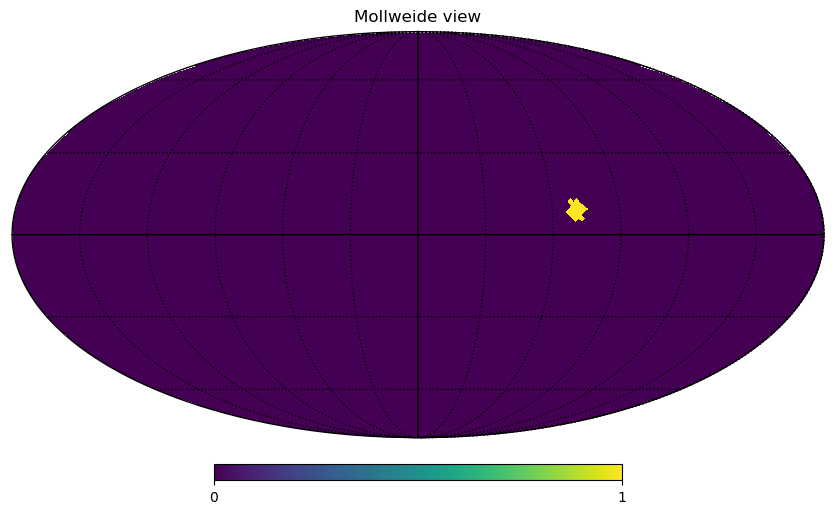

In [79]:
ra_center = 290.0
dec_center = 10.0
radius = 10.0
region_pixels = calc_hp_for_region(ra_center, dec_center, radius, sky_area.nside)

idx = np.where(galplane_footprint == 1.0)[0]
blob_pixels = np.intersect1d(region_pixels, idx)

blob_map = np.zeros(NPIX)
blob_map[blob_pixels] = 1.0

plot_map_data(blob_map)

This is great, but the Blob map from the scheduler has NSIDE=32 whereas the science priority maps have NSIDE=64, so we need to resample before we can compare them. 

In [83]:
scimap_nside = 64
scimap_npix = hp.nside2npix(scimap_nside)
print(str(scimap_npix) + ' HEALpixels corresponds to NSIDE=' + str(scimap_nside))

blob_footprint = hp.ud_grade(blob_map, scimap_nside)

49152 HEALpixels corresponds to NSIDE=64


Now we can explore how this Blob overlaps with the various maps of regions of scientific priority.

In [84]:
def load_map_data(map_file_path):
    with fits.open(map_file_path) as hdul:
        map_data_table = hdul[1].data
    return map_data_table

In [85]:
data_dir = '/Users/rstreet/rubin_sim_data/maps/scheduler_maps/maps/GalacticPlanePriorityMaps'
priority_map_file = path.join(data_dir, 'priority_GalPlane_footprint_map_data_sum.fits')

sci_map_data = load_map_data(priority_map_file)
sci_map_data.columns

ColDefs(
    name = 'combined_map'; format = 'E'
    name = 'galactic_plane_map'; format = 'E'
    name = 'magellenic_clouds_map'; format = 'E'
    name = 'galactic_bulge_map'; format = 'E'
    name = 'clementini_stellarpops_map'; format = 'E'
    name = 'bonito_sfr_map'; format = 'E'
    name = 'globular_clusters_map'; format = 'E'
    name = 'open_clusters_map'; format = 'E'
    name = 'zucker_sfr_map'; format = 'E'
    name = 'pencilbeams_map'; format = 'E'
    name = 'xray_binaries_map'; format = 'E'
)

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_48935/342435702.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


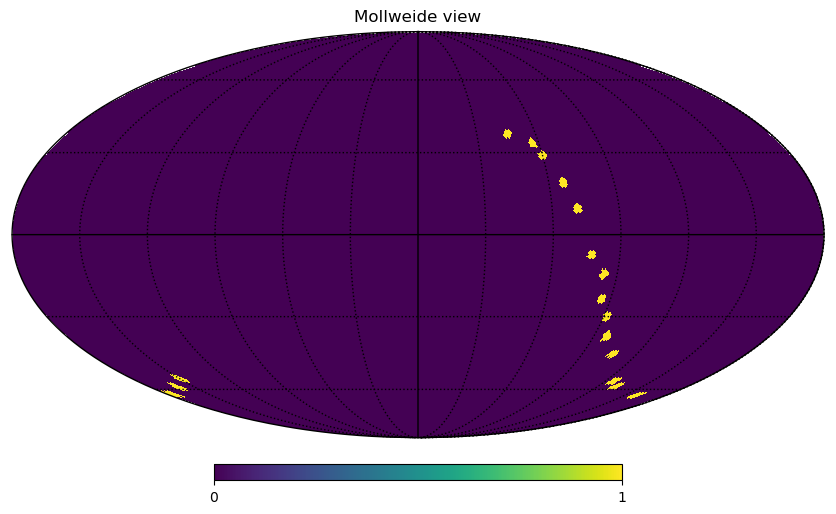

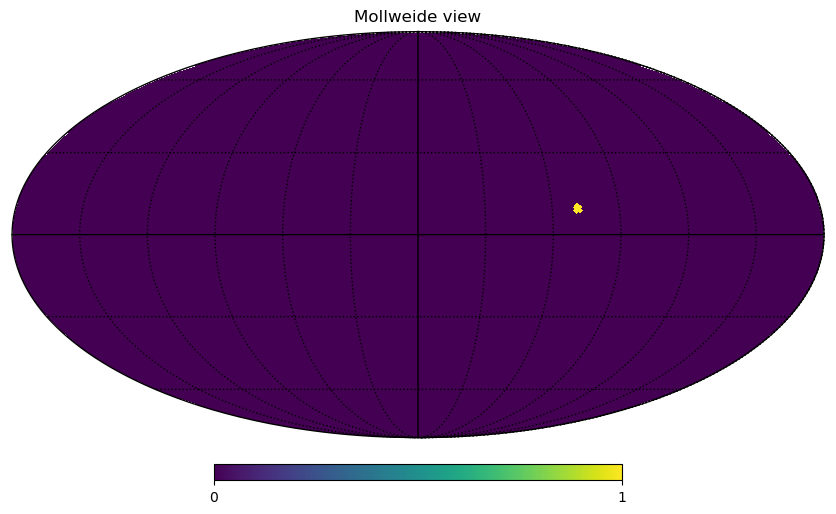

In [91]:
map_name = 'pencilbeams_map'

sci_map = np.zeros(scimap_npix)
mask = sci_map_data[map_name] > 0.5
sci_map[mask] = 1.0

plot_map_data(sci_map)

idx1 = np.where(sci_map_data[map_name] > 0.5)[0]
idx2 = np.where(blob_footprint == 1.0)[0]
diff_mask = np.intersect1d(idx1, idx2)

diff_map = np.zeros(scimap_npix)
diff_map[diff_mask] = 1.0

plot_map_data(diff_map)

In [98]:
check_maps = sci_map_data.columns
scimap_pixarea = hp.nside2pixarea(scimap_nside, degrees = True)  

for map_name in check_maps:
    sci_map = np.zeros(scimap_npix)
    mask = sci_map_data[map_name.name] > 0.5
    sci_map[mask] = 1.0
    idx1 = np.where(sci_map_data[map_name.name] > 0.5)[0]
    idx2 = np.where(blob_footprint == 1.0)[0]
    diff_mask = np.intersect1d(idx1, idx2)
    overlap_area = scimap_pixarea * len(diff_mask)
    print('Blob overlaps ' + map_name.name + ' by ' + str(len(diff_mask)) + 'healpix, or ' + str(overlap_area) + 'deg')

Blob overlaps combined_map by 56healpix, or 47.00044413182534deg
Blob overlaps galactic_plane_map by 56healpix, or 47.00044413182534deg
Blob overlaps magellenic_clouds_map by 0healpix, or 0.0deg
Blob overlaps galactic_bulge_map by 0healpix, or 0.0deg
Blob overlaps clementini_stellarpops_map by 0healpix, or 0.0deg
Blob overlaps bonito_sfr_map by 0healpix, or 0.0deg
Blob overlaps globular_clusters_map by 0healpix, or 0.0deg
Blob overlaps open_clusters_map by 0healpix, or 0.0deg
Blob overlaps zucker_sfr_map by 0healpix, or 0.0deg
Blob overlaps larger_pencilbeams_map by 0healpix, or 0.0deg
Blob overlaps xray_binaries_map by 0healpix, or 0.0deg


So it looks like the only science region impacted by the removal of the Blob is one of the Galactic Plane pencilbeams that was put in to ensure a wide range of galactic lines of sight were covered.  The v3.X Galactic Plane footprint map largely achieves this goal already, with fields that are at more accessible airmass, so this is not a serious concern. 

As a sanity check, let's compare the Blob with the alternative pencilbeams that were proposed based on only key galactic lines of sight, rather than a range of galactic longitude.

In [94]:
priority_map_file = path.join(data_dir, 'priority_GalPlane_footprint_alt_map_data_sum.fits')

sci_map_data = load_map_data(priority_map_file)
sci_map_data.columns

ColDefs(
    name = 'combined_map'; format = 'E'
    name = 'galactic_plane_map'; format = 'E'
    name = 'magellenic_clouds_map'; format = 'E'
    name = 'galactic_bulge_map'; format = 'E'
    name = 'clementini_stellarpops_map'; format = 'E'
    name = 'bonito_sfr_map'; format = 'E'
    name = 'globular_clusters_map'; format = 'E'
    name = 'open_clusters_map'; format = 'E'
    name = 'zucker_sfr_map'; format = 'E'
    name = 'larger_pencilbeams_map'; format = 'E'
    name = 'xray_binaries_map'; format = 'E'
)

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_48935/342435702.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


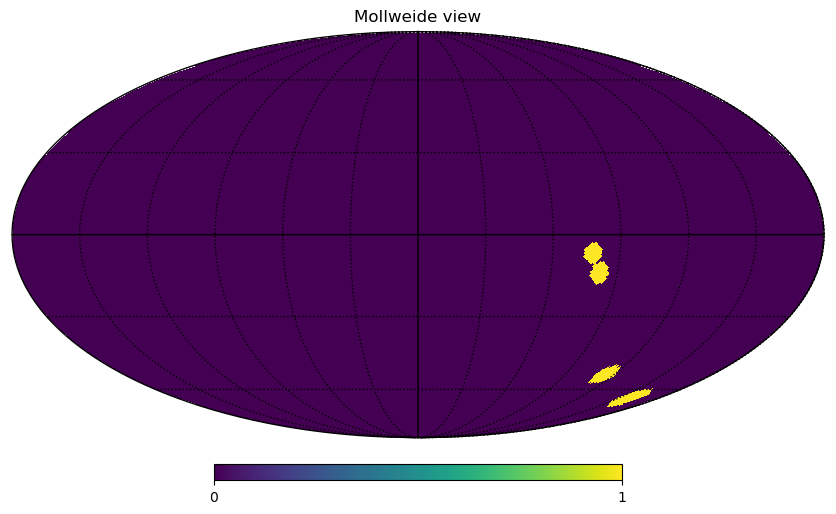

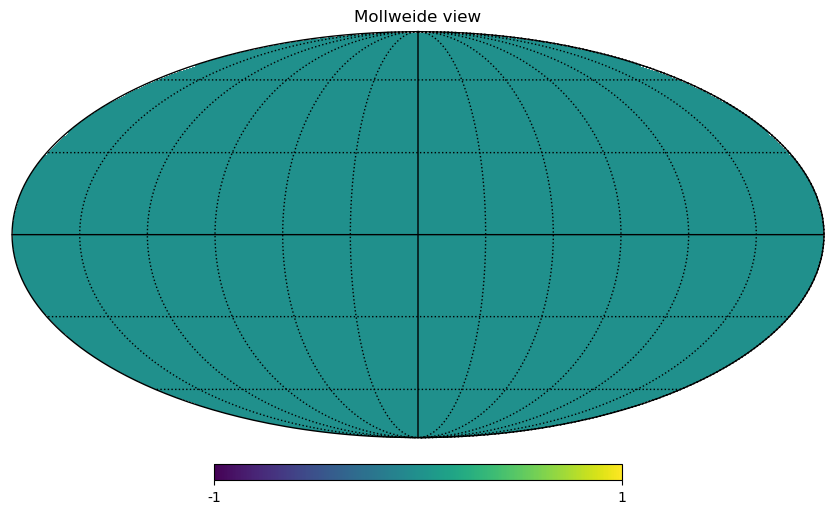

In [95]:
map_name = 'larger_pencilbeams_map'

sci_map = np.zeros(scimap_npix)
mask = sci_map_data[map_name] > 0.5
sci_map[mask] = 1.0

plot_map_data(sci_map)

idx1 = np.where(sci_map_data[map_name] > 0.5)[0]
idx2 = np.where(blob_footprint == 1.0)[0]
diff_mask = np.intersect1d(idx1, idx2)

diff_map = np.zeros(scimap_npix)
diff_map[diff_mask] = 1.0

plot_map_data(diff_map)

This confirms that the Blob, while nice to have to sample lines of sight at this galactic longitude, can be removed with relatively little science impact, provided the rest of the Galactic Plane survey footprint is retained, as this already covers quite a wide range.  The Blob was included in the combined map because it was selected from the map of stellar density of the Galactic Plane rather than for a specific science area.  That implies it is an area of relatively low extinction and high star count.  While valuable for the data on those stars, by themselves it is a less compelling science case since the data quality will be lower at high airmass. 